# Radar processing chain of QVPs scans using UK Met Office radar data.

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

## This notebook describes the process of retrieving, quality-check and processing raw C-band radar data collected by the operational UK Met Office radar network.

UK Met Office C-band rain radar dual-polarisation products are available at http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499 (Met Office, 2003)

### Import relevant packages

In [1]:
import towerpy as tp
import cartopy.crs as ccrs

%matplotlib notebook


You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:





### Define working directory and file name

For this example, we'll use data collected at the Chenies radar site; In the file name, *augzdr* stands for polarimetric data, *sp* for short-pulse and *el4* refers to collected at 9.0&deg; elevation angle.

In [3]:
rsite = 'chenies'
fdir = f'../datasets/{rsite}/y2020/spel4/'
fname = (f'metoffice-c-band-rain-radar_{rsite}_202010030730_raw-dual-polar-'
         + 'augzdr-sp-el4.dat')

### Use Towerpy to read in the raw radar variables.

The **Rad_scan class** initialises a radar object. 

Within the **ukmo module**, the *ppi_ukmoraw* function provides an interface to read the current binary format used by the MO to store the radar data.

Note that the argument *exclude_vars* was used to discard the 'W [m/s]', 'SQI [-]' and 'CI [dB]'] variables, as they  will not be used at this stage.

<IPython.core.display.Javascript object>


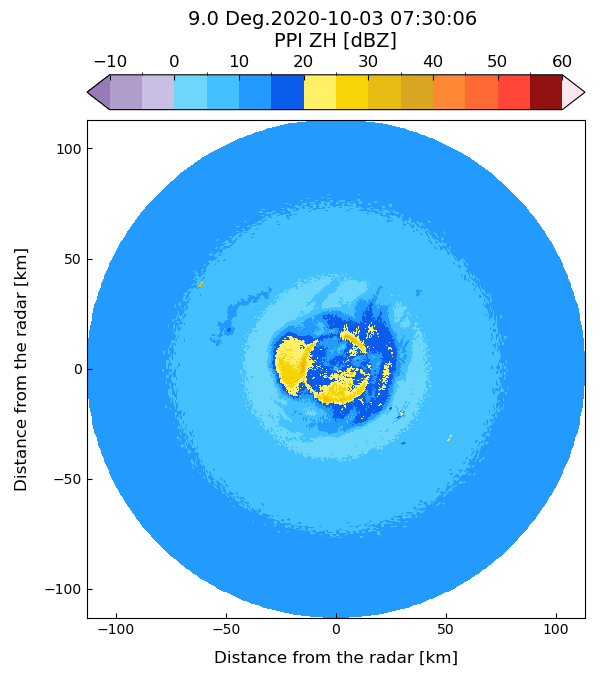

<IPython.core.display.Javascript object>


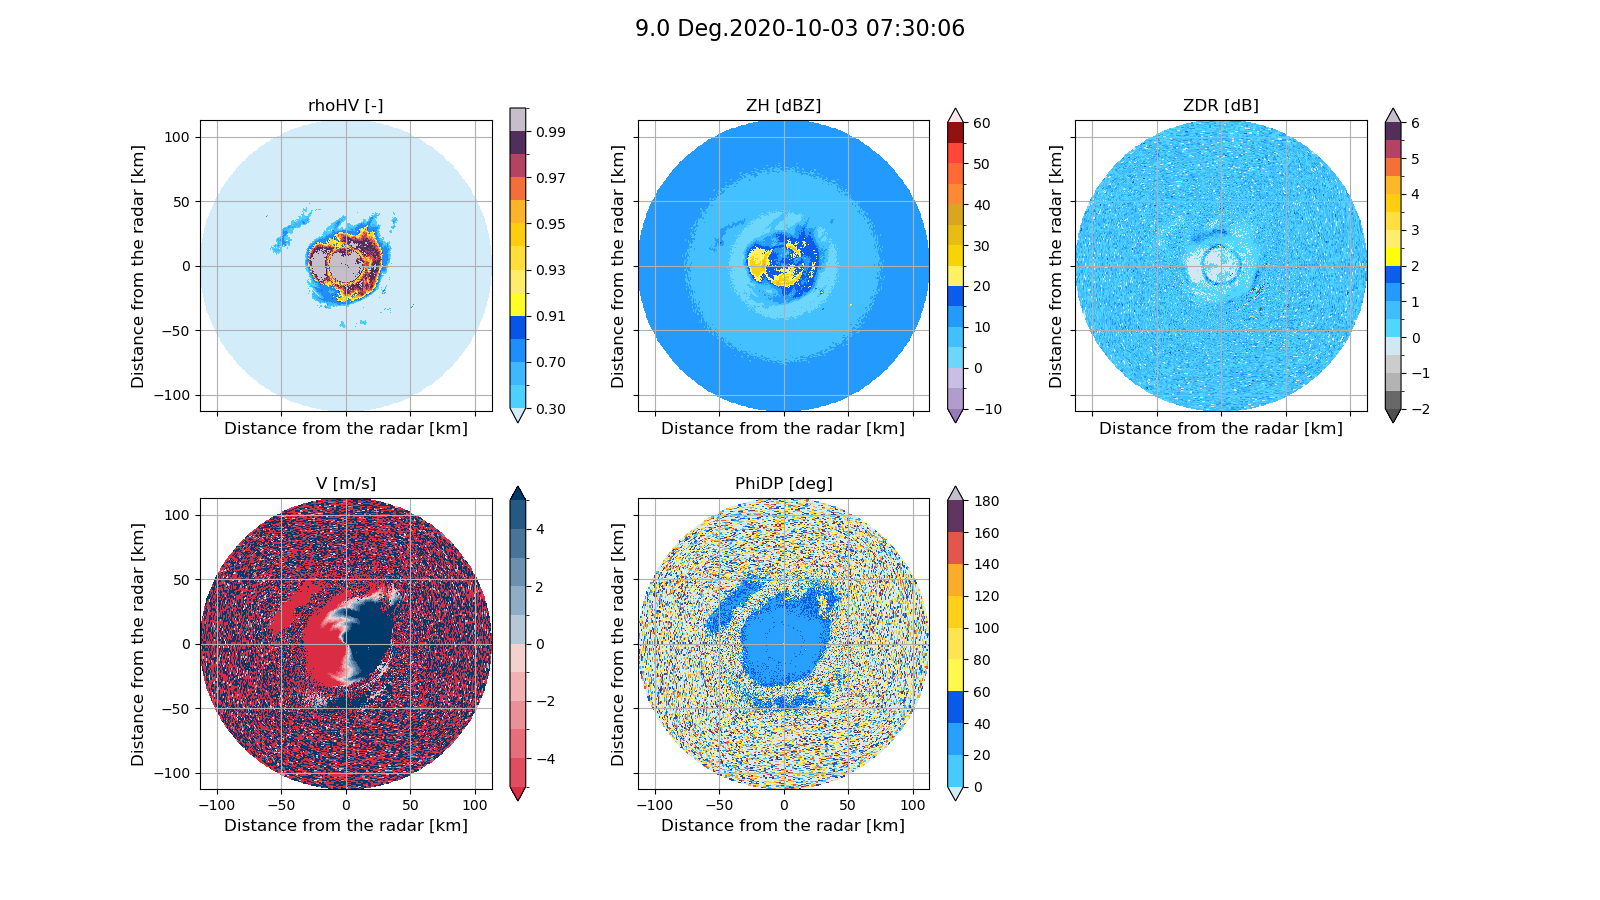

In [4]:
rdata = tp.io.ukmo.Rad_scan(fdir+fname, rsite)
rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])

tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rdata.vars)
tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

### Computation of the Signal-to-Noise-Ratio

We use the *signalnoiseratio* function to compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value equal to 55 dB.
This value had been checked at all the UK Met office radar sites (valid only for short-pulse scans) and proved effective in removing noise within the scans.

The *data2correct* argument copies the original data and generates a new dictionary containing radar variables but SNR filtered.

<IPython.core.display.Javascript object>


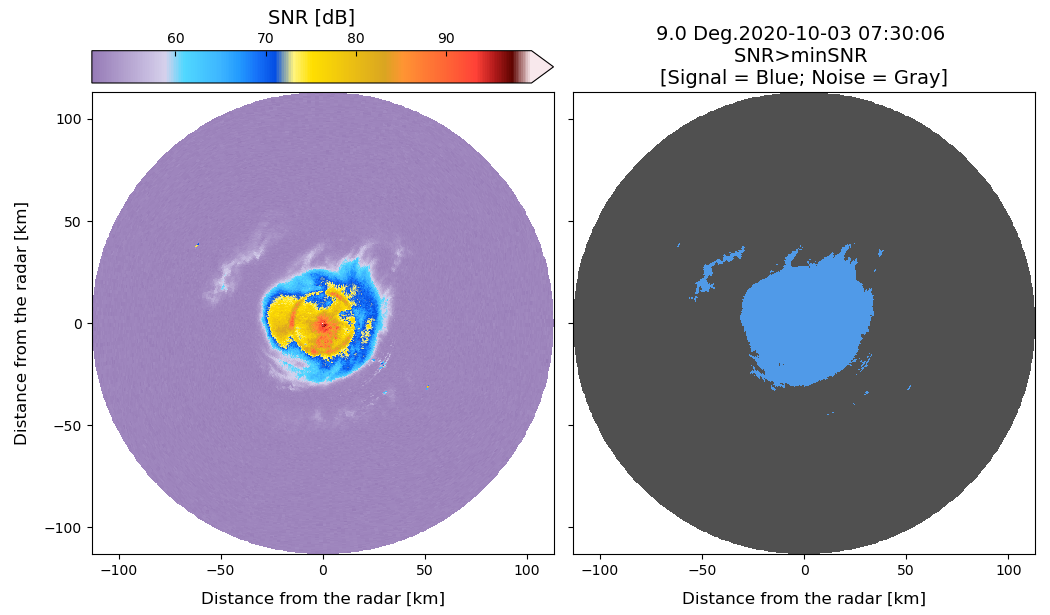

In [5]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars, min_snr=55,
                      data2correct=rdata.vars, plot_method=(True))

### Generation of QVPs of polarimetric variables

We use the *pol_qvps* function to generate quasi-vertical profiles of polarimetric variables.

Note that the argument *stats* is set to True to compute statistics related to the averaging process of the rays to enable a comprehensive analysis of the profiles.

In [8]:
rprofs = tp.profs.polprofs.PolarimetricProfiles(rdata)
rprofs.pol_qvps(rdata.georef, rdata.params, rsnr.vars, stats=True)

Use the *plot_radprofiles* function to view the QVPs.

<IPython.core.display.Javascript object>


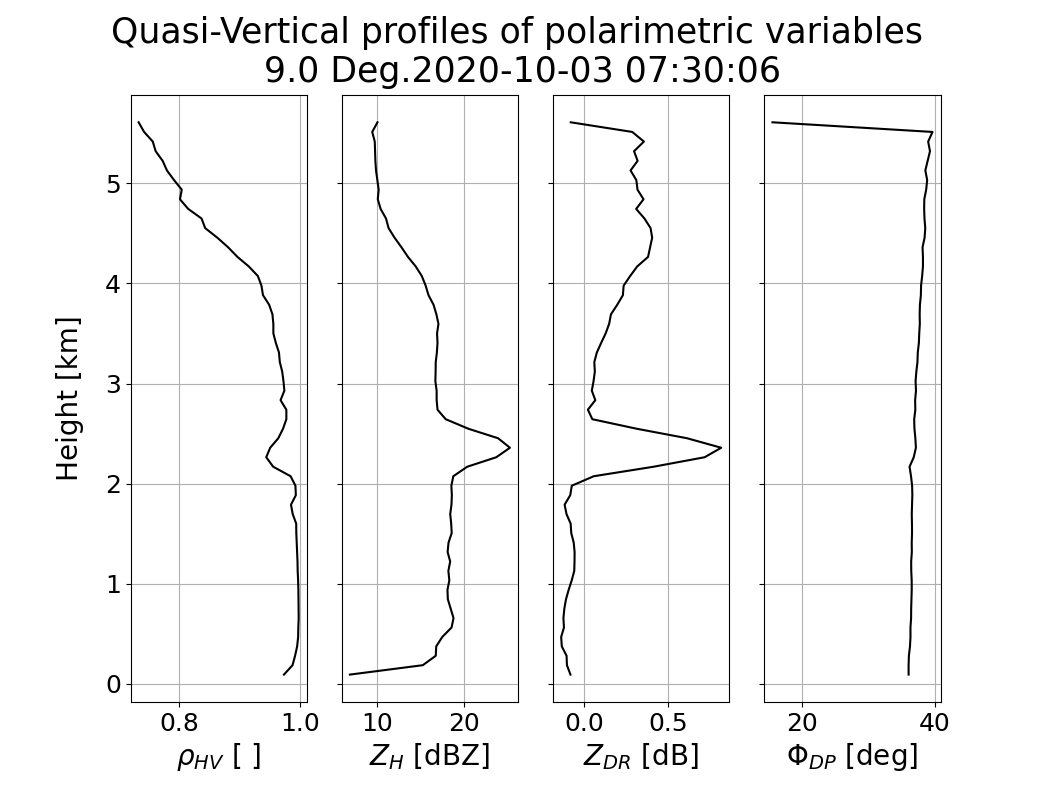

In [9]:
tp.datavis.rad_display.plot_radprofiles(rdata.params,
                                        rprofs.georef['profiles_height [km]'],
                                        rprofs.qvps)

### ML detection

Then we will run the method proposed by Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2021) to detect the boundaries of the ML within the QVPs.

In the *ml_detection* function, we set a minimum height for the algorithm to search the ML signatures. The user can modify this and other arguments to fine-tune the algorithm's performance.

Note that the *plot_method* argument is set to True. This argument displays an **interactive plot** that illustrates the steps followed by the ML detection algorithm. As the method computes all the possible combinations of the normalised profiles, it is possible to check each one by moving the slider.

<IPython.core.display.Javascript object>


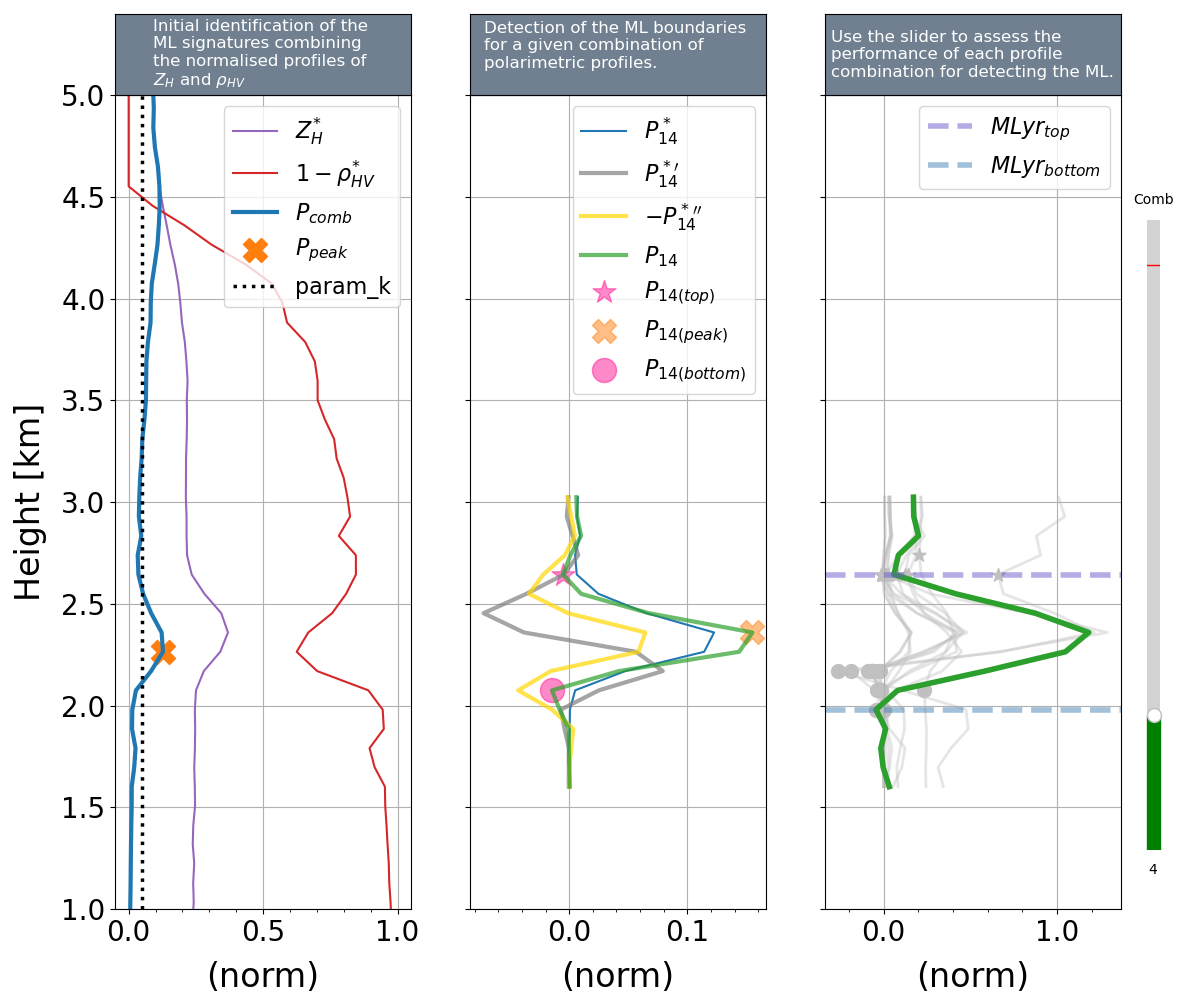

In [10]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
rmlyr.ml_detection(rprofs, min_h=0.25, comb_id=14, plot_method=True)

In [11]:
rmlyr.ml_top

2.6442825147678377

In [12]:
rmlyr.ml_thickness

0.569356063449959

In [13]:
rmlyr.ml_bottom

2.0749264513178787

### $Z_{DR}$ offset detection

The *offsetdetection_qvps* function adapts the method proposed by Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2022) to detect the $Z_{DR}$ offset using QVPs.

The *mlyr* is required to separate between liquid and solid precipitation. Whereas the *min_h* and other arguments help adjust the algorithm's performance.

According to this method, the intrinsic value of $Z_{DR}$ in light rain at ground level is required. The default for this radar is 0.182. See the paper for a more detailed description.

In [18]:
rcalzdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
rcalzdr.offsetdetection_qvps(pol_profs=rprofs, mlyr=rmlyr, min_h=0.25, zdr_0=0.182)

In [20]:
rcalzdr.zdr_offset

-0.2755357495838535

## References

Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499

Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2021), "Detection of the melting level with polarimetric weather radar" in Atmospheric Measurement Techniques Journal, Volume 14, issue 4, pp. 2873–2890, 13 Apr 2021 https://doi.org/10.5194/amt-14-2873-2021

Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2022): "Calibration of radar differential reflectivity using quasi-vertical profiles", Atmos. Meas. Tech., 15, 503–520, https://doi.org/10.5194/amt-15-503-2022